In [13]:
# libraries
import glob
import mne
from mne import grand_average
from tqdm import tqdm

import os
import numpy as np
%matplotlib widget
from os import chdir, makedirs
from os.path import join
import matplotlib.pyplot as plt ## for basic plotting
import matplotlib as mpl ## for setting default parameters
import pandas as pd

# decoding libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from scipy.stats import ttest_1samp

In [14]:
subjects_dir = '/work/freesurfer'

In [15]:
# get epoch filepaths
epo_files = sorted(glob.glob(f"epochs/*.fif"))

# get fwd models filepaths
fwd_files = sorted(glob.glob(f"models/*.fif"))

epo_files, fwd_files

(['epochs/0163-epo.fif',
  'epochs/0164-epo.fif',
  'epochs/0165-epo.fif',
  'epochs/0166-epo.fif',
  'epochs/0167-epo.fif',
  'epochs/0168-epo.fif',
  'epochs/0169-epo.fif',
  'epochs/0170-epo.fif'],
 ['models/0163-fwd.fif',
  'models/0164-fwd.fif',
  'models/0165-fwd.fif',
  'models/0166-fwd.fif',
  'models/0167-fwd.fif',
  'models/0168-fwd.fif',
  'models/0169-fwd.fif',
  'models/0170-fwd.fif'])

In [16]:
# function for creating averages (evoked responses) and difference waves
def compute_evoked_diff(epochs):
    evokeds = list()
    for event in epochs.event_id:
        evokeds.append(epochs[event].average())

    diffs_comment = ['ACE - NE'] #CHANGE to test different contrasts
    diffs = [(2,0)] # PAS 1-3 contrast CHANGE to test different contrasts
    for diff in diffs:
        evoked_diff = evokeds[diff[0]].copy() # create a copy
        evoked_diff.data -= evokeds[diff[1]].data # modify the data in place
        evoked_diff.comment = diffs_comment
    
    return evoked_diff

  0%|          | 0/8 [00:00<?, ?it/s]

Loaded epochs/0163-epo.fif and models/0163-fwd.fif


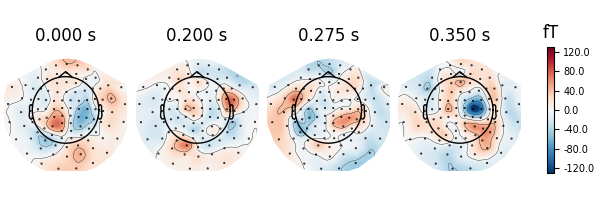

 12%|█▎        | 1/8 [00:04<00:28,  4.04s/it]

Loaded epochs/0164-epo.fif and models/0164-fwd.fif


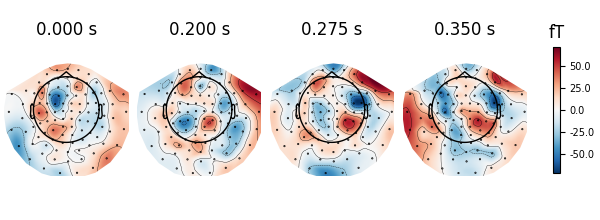

 25%|██▌       | 2/8 [00:08<00:25,  4.33s/it]

Loaded epochs/0165-epo.fif and models/0165-fwd.fif


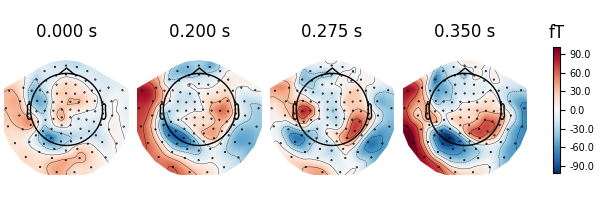

 38%|███▊      | 3/8 [00:13<00:22,  4.42s/it]

Loaded epochs/0166-epo.fif and models/0166-fwd.fif


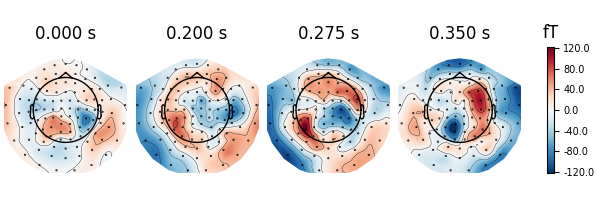

 50%|█████     | 4/8 [00:17<00:17,  4.38s/it]

Loaded epochs/0167-epo.fif and models/0167-fwd.fif


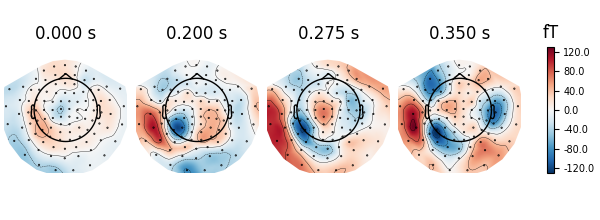

 62%|██████▎   | 5/8 [00:21<00:12,  4.11s/it]

Loaded epochs/0168-epo.fif and models/0168-fwd.fif


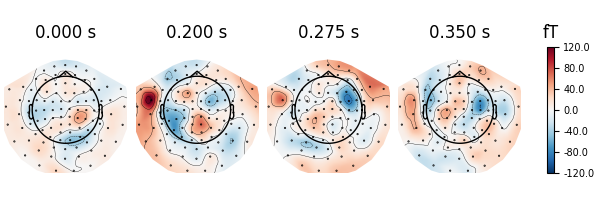

 75%|███████▌  | 6/8 [00:26<00:08,  4.50s/it]

Loaded epochs/0169-epo.fif and models/0169-fwd.fif


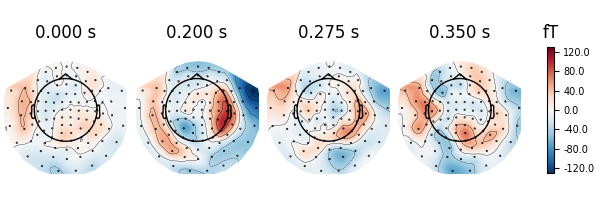

 88%|████████▊ | 7/8 [00:32<00:04,  4.96s/it]

Loaded epochs/0170-epo.fif and models/0170-fwd.fif


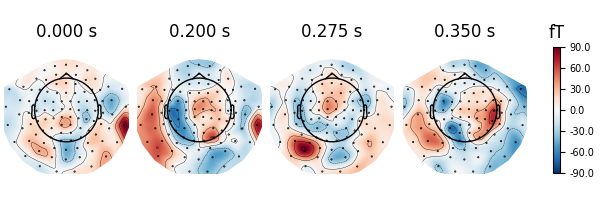

100%|██████████| 8/8 [00:38<00:00,  4.86s/it]


In [17]:
mne.set_log_level('WARNING') # turning off verbose so loadbar is updated in-place

epochs_group = []
fwds_group = []
evoked_diffs = []

# for each subject
for epo_file, fwd_file in tqdm(zip(epo_files, fwd_files), total=len(epo_files)):

    # load epochs and fwd model
    epochs = mne.read_epochs(epo_file)
    fwd = mne.read_forward_solution(fwd_file)

    # compute difference wave
    evoked_diff = compute_evoked_diff(epochs)

    # store in group lists
    epochs_group.append(epochs)
    fwds_group.append(fwd)
    evoked_diffs.append(evoked_diff)

    # do stuff for each participant
    print(f"Loaded {epo_file} and {fwd_file}")
    fig = mne.viz.plot_evoked_topomap(evoked_diff, times=[0, 0.2, 0.275, 0.35])

In [18]:
# access each subjects epochs
epochs_group[0] # first participant

<EpochsFIF | 392 events (all good), -0.2 – 0.55 s (baseline -0.2 – 0 s), ~708.3 MiB, data loaded,
 'NE': 102
 'WG': 238
 'ACE': 52>

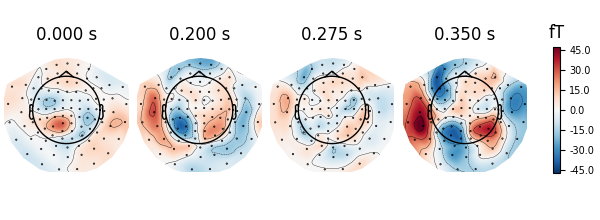

Text(0.5, 0.98, 'Group-level ACE–NE difference')

In [19]:
# compute group average
grand_avg = grand_average(evoked_diffs)

# plot
fig = mne.viz.plot_evoked_topomap(grand_avg, times=[0, 0.2, 0.275, 0.35])
fig.suptitle('Group-level ACE–NE difference', fontsize=16) #CHANGE title when changing comparison

In [20]:
epochs_decoding = epochs_group

In [21]:
##FILTERING as to only use events NE and CE

# And the event codes you want to keep are 21 and 24

epochs_filtered =[]

for epoch in epochs_group:
    filter_events = [21, 23]
    # Create a boolean mask for the epochs you want
    mask = np.isin(epoch.events[:, 2], filter_events)
    # Apply the mask to get filtered epochs
    epochs_filtered.append(epoch[mask])



/tmp/ipykernel_1223/514158355.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,4))


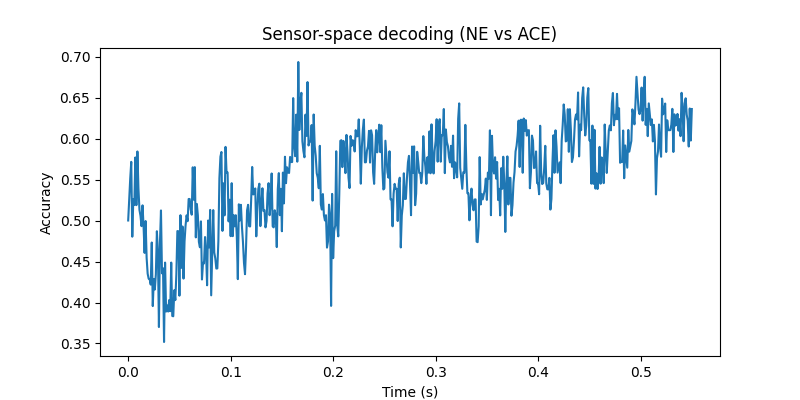

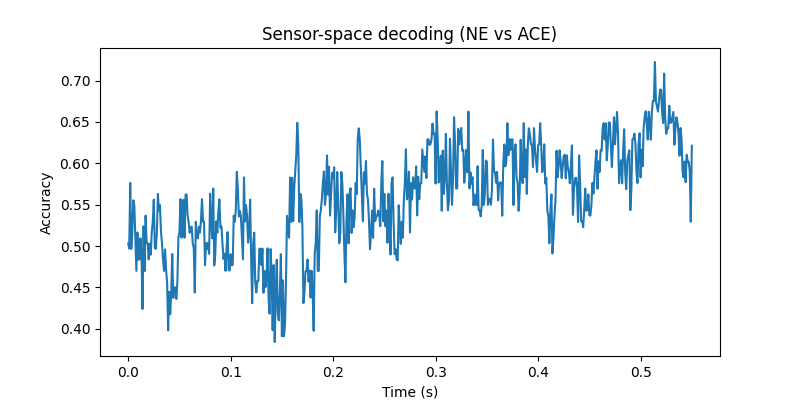

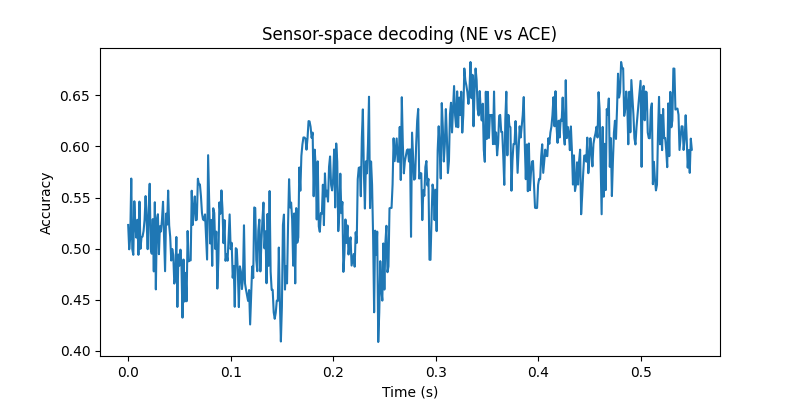

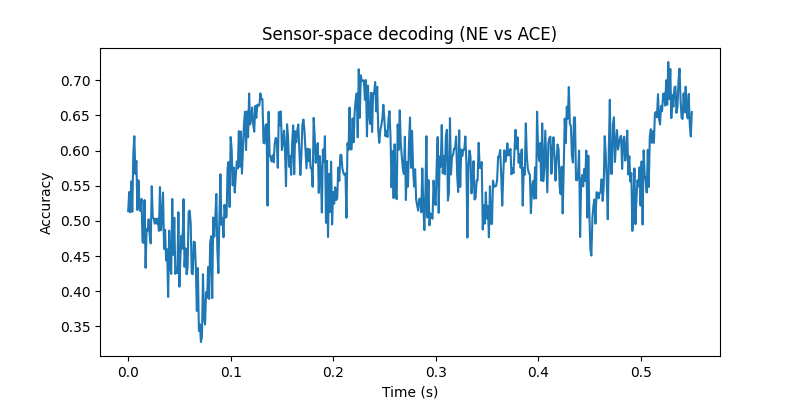

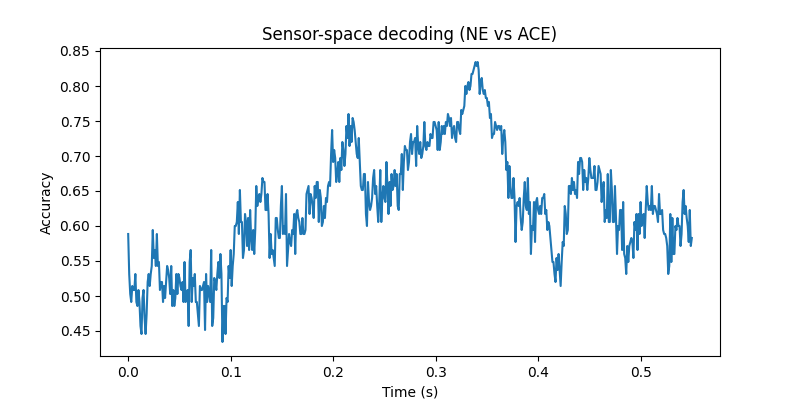

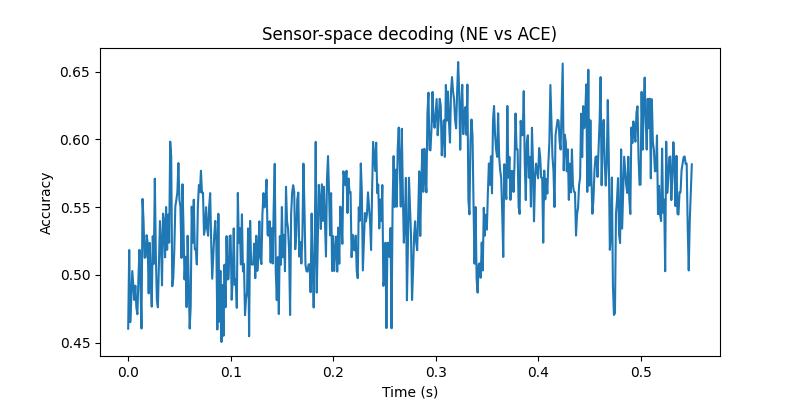

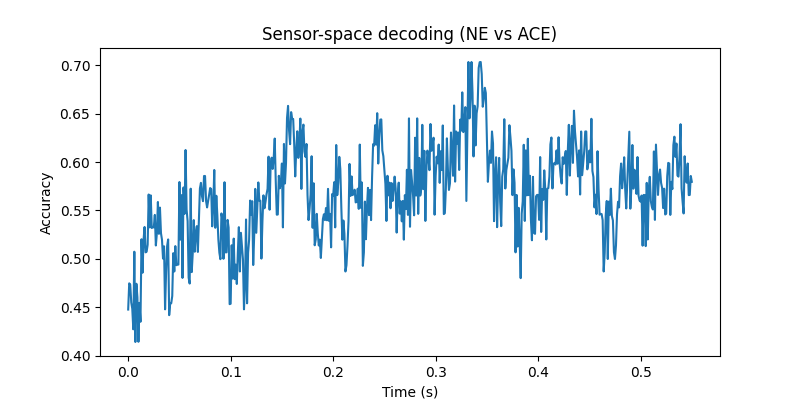

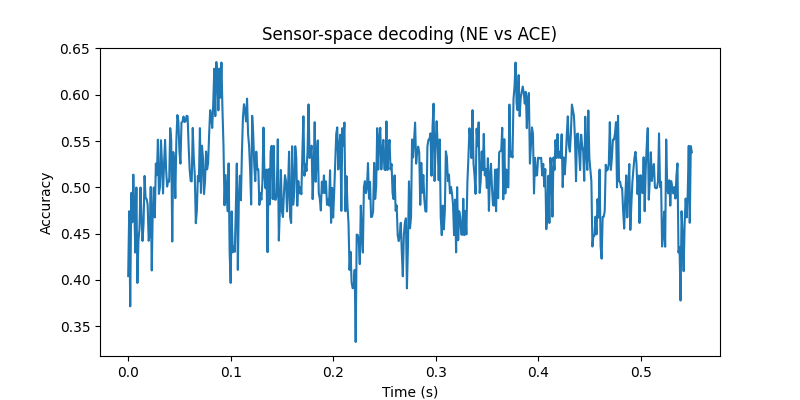

In [22]:
## LOOP for decoding in sensor space - and plotting individual timecourses
 
# -------------------------------
# PARAMETERS
# -------------------------------
n_jobs_outer = 64
decimation = 1
cv_folds = 5
C_reg = 1e-3
n_skip = 200  # discard first 200 samples

group_level_scores_sensor = []

for subj in epochs_filtered:    
    X = subj.get_data()  # shape = (n_events, n_channels, n_times)
    y = subj.events[:, 2]
    
    # Drop pre-stim samples
    X = X[:, :, n_skip:][:, :, ::decimation]
    times = subj.times[n_skip:][::decimation]
    n_events, n_channels, n_samples = X.shape

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True)
    logr = LogisticRegression(C=C_reg, solver='liblinear', max_iter=1000)
    sc = StandardScaler()

    def decode_time_sample(sample_idx):
        this_X = X[:, :, sample_idx]
        this_X_std = sc.fit_transform(this_X)
        score = np.mean(cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=1))
        return score

    scores_list_samples = Parallel(n_jobs=n_jobs_outer)(
        delayed(decode_time_sample)(t) for t in range(n_samples)
    )
    # -------------------------------
    # PLOT RESULTS
    # -------------------------------
    plt.figure(figsize=(8,4))
    plt.plot(times, scores_list_samples)
    plt.title('Sensor-space decoding (NE vs ACE)')
    plt.xlabel('Time (s)')
    plt.ylabel('Accuracy')
    plt.show()


    group_level_scores_sensor.append(scores_list_samples)







In [23]:
#aggregating
# Convert to NumPy array
arr = np.array(group_level_scores_sensor)   # shape = (n_subjects, n_timepoints)

# Compute mean across subjects (axis 0)
mean_timecourse_sensor = np.mean(arr, axis=0)

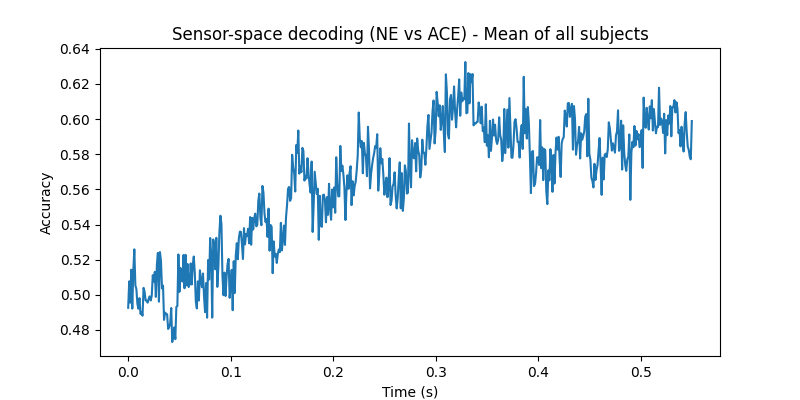

In [24]:
# -------------------------------
# PLOT RESULTS - group level accuracy
# -------------------------------
plt.figure(figsize=(8,4))
plt.plot(times, mean_timecourse_sensor)
plt.title('Sensor-space decoding (NE vs ACE) - Mean of all subjects')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.show()



In [25]:
#performing a whole lot of t-tests
n_subjects, n_timepoints = arr.shape

chance_level = 0.5

t_vals = np.zeros(n_timepoints)
p_vals = np.zeros(n_timepoints)

for t in range(n_timepoints):
    t_stat, p_val = ttest_1samp(arr[:, t], popmean=chance_level)
    t_vals[t] = t_stat
    p_vals[t] = p_val

significance = p_vals<=0.05

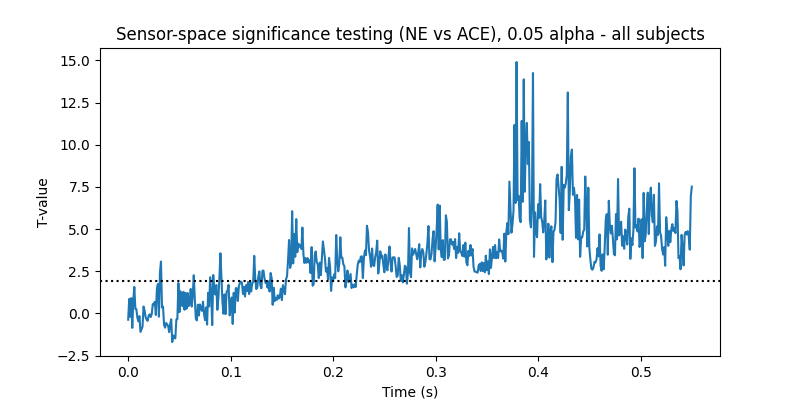

In [26]:
#plotting t-values
plt.figure(figsize=(8,4))
plt.plot(times, t_vals)
plt.title('Sensor-space significance testing (NE vs ACE), 0.05 alpha - all subjects')
plt.xlabel('Time (s)')
plt.ylabel('T-value')
plt.axhline(y=1.90, color='k', linestyle=':', label='Significance threshold')
plt.show()

In [27]:
## deocoding in sensor space
# - Original 1 at a time,  is not built to take a list and will not run unless fed a slightly different input
# -------------------------------
# PARAMETERS
# -------------------------------
n_jobs_outer = 64
decimation = 1
cv_folds = 5
C_reg = 1e-3
n_skip = 200  # discard first 200 samples

# -------------------------------
# USE SENSOR-LEVEL EPOCHS DIRECTLY
# -------------------------------
# (assume epochs_filtered contains only your relevant events)
X = epochs_filtered.get_data()  # shape = (n_events, n_channels, n_times)
y = epochs_filtered.events[:, 2]

# Optional: restrict to MEG or EEG channels only
# picks = mne.pick_types(epochs_filtered.info, meg=True, eeg=False)
# X = epochs_filtered.get_data(picks=picks)

# Drop pre-stim samples
X = X[:, :, n_skip:][:, :, ::decimation]
times = epochs_filtered.times[n_skip:][::decimation]
n_events, n_channels, n_samples = X.shape

# -------------------------------
# CLASSIFIER SETUP
# -------------------------------
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True)
logr = LogisticRegression(C=C_reg, solver='liblinear', max_iter=1000)
sc = StandardScaler()

# -------------------------------
# FUNCTION FOR SINGLE TIME SAMPLE
# -------------------------------
def decode_time_sample(sample_idx):
    this_X = X[:, :, sample_idx]
    this_X_std = sc.fit_transform(this_X)
    score = np.mean(cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=1))
    return score

# -------------------------------
# PARALLEL DECODING
# -------------------------------
scores_list_samples = Parallel(n_jobs=n_jobs_outer)(
    delayed(decode_time_sample)(t) for t in range(n_samples)
)

# -------------------------------
# PLOT RESULTS
# -------------------------------
plt.figure(figsize=(8,4))
plt.plot(times, scores_list_samples)
plt.title('Sensor-space decoding (NE vs CE) - Subject 0169')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.show()


AttributeError: 'list' object has no attribute 'get_data'

  0%|          | 0/8 [00:00<?, ?it/s]

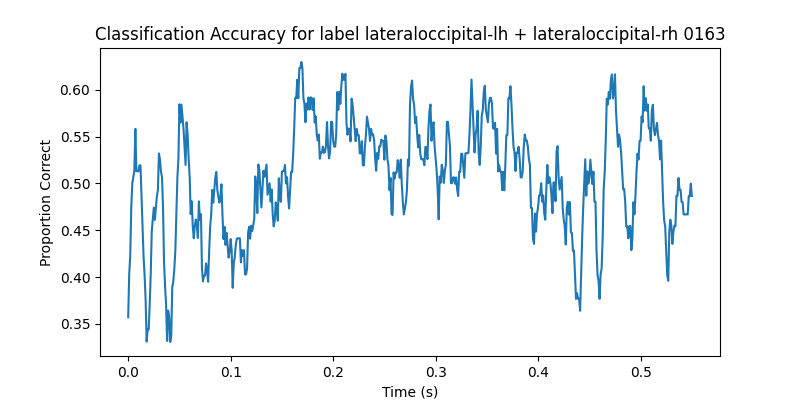

 12%|█▎        | 1/8 [00:54<06:19, 54.15s/it]

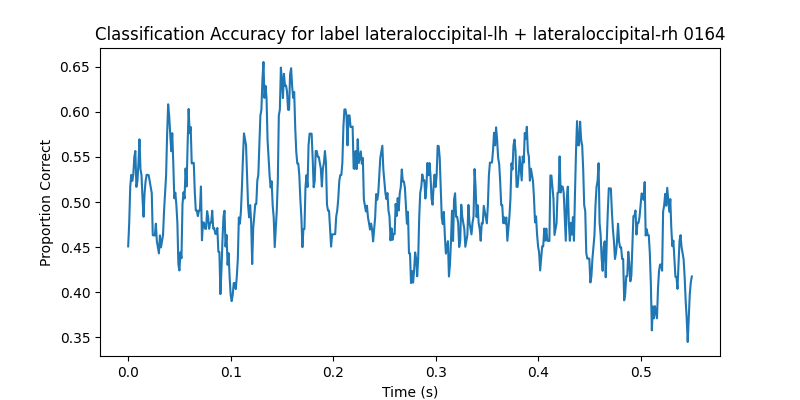

 25%|██▌       | 2/8 [01:42<05:04, 50.74s/it]

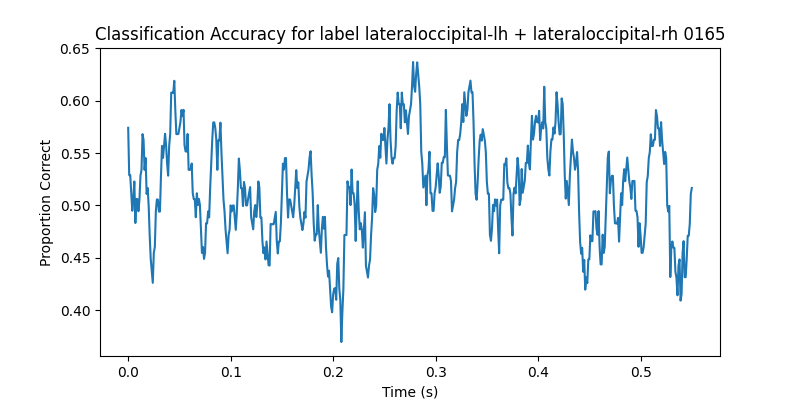

 38%|███▊      | 3/8 [02:37<04:22, 52.52s/it]

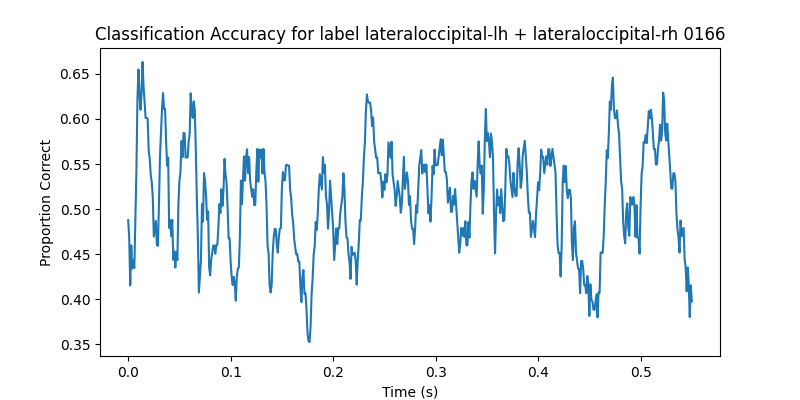

 50%|█████     | 4/8 [03:11<03:01, 45.37s/it]

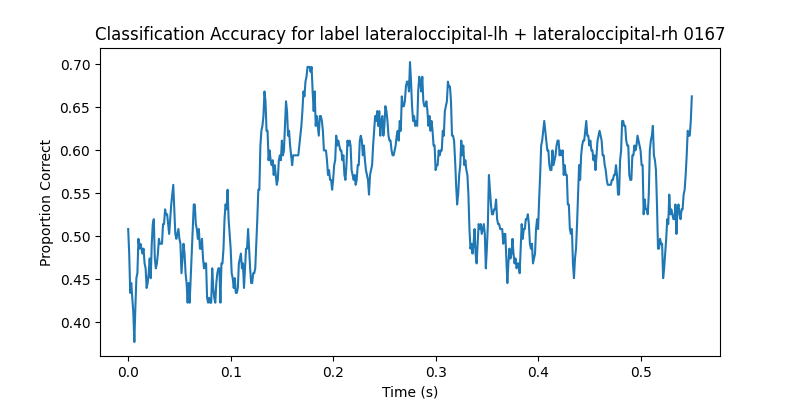

 62%|██████▎   | 5/8 [04:01<02:21, 47.01s/it]

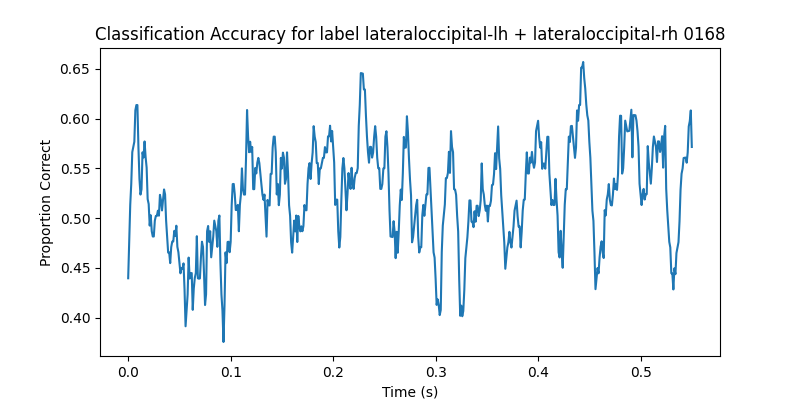

 75%|███████▌  | 6/8 [05:00<01:42, 51.22s/it]

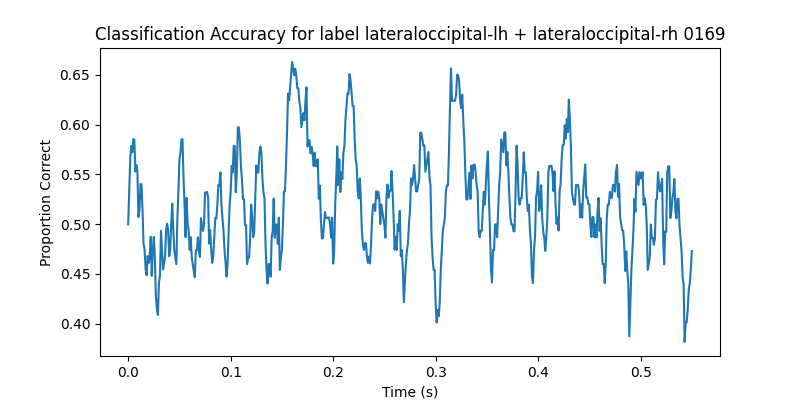

 88%|████████▊ | 7/8 [05:46<00:49, 49.32s/it]

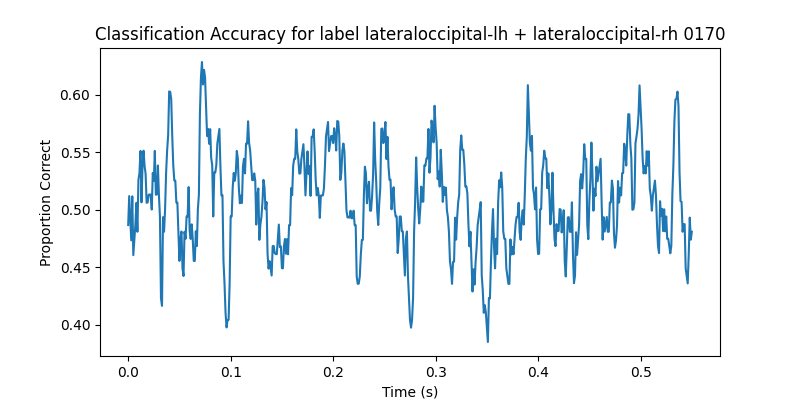

100%|██████████| 8/8 [06:37<00:00, 49.72s/it]


In [ ]:
# PARAMETERS

# -------------------------------

n_jobs_outer = 64   # number of cores for time point parallelization

decimation = 1      # take every N-th sample (1 = no decimation)

cv_folds = 5

C_reg = 1e-3

label_index = -1    # label to decode  - this is lateral occipital

n_skip = 200        # number of initial samples to discard (pre-0 ms)

subj_list=['0163','0164','0165','0166','0167','0168','0169','0170']

group_level_scores_source = []

# GROUP LEVel source space decoding
for epoch, fwd, subj in tqdm(zip(epochs_filtered, fwds_group, subj_list), total=len(epochs_group)):
    noise_cov = mne.compute_covariance(epoch, tmin=None, tmax=0)
    #noise_cov.plot(epoch.info)
    inverse_operator = mne.minimum_norm.make_inverse_operator(epoch.info, fwd,
                                                          noise_cov)

    stcs = mne.minimum_norm.apply_inverse_epochs(

    epoch, inverse_operator, lambda2=1, method='dSPM'
    )

    labels = mne.read_labels_from_annot(subj, subjects_dir=subjects_dir)

    occipital_label = labels[22] + labels[23]

    labels.append(occipital_label)
    
    def extract_label(label, stcs):

        return [stc.in_label(label) for stc in stcs]

  
    label_stcs = [extract_label(label, stcs) for label in labels]

    stcs_for_label = label_stcs[label_index]

    label_name = labels[label_index].name

    n_events = len(stcs_for_label)

    n_label_vertices = stcs_for_label[0].data.shape[0]
    n_samples = stcs_for_label[0].data.shape[1]
    X = np.zeros((n_events, n_label_vertices, n_samples))

    for i in range(n_events):

        X[i, :, :] = stcs_for_label[i].data

    #discarding precognition
    X = X[:, :, n_skip:]
    times = stcs_for_label[0].times[n_skip:]
    n_samples = X.shape[2]
    #building labels
    y = epoch.events[:, 2]

    #setting up decoding
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    logr = LogisticRegression(C=C_reg, solver='liblinear', max_iter=1000)
    sc = StandardScaler()

    def decode_time_sample(sample_idx):

        this_X = X[:, :, sample_idx]

        this_X_std = sc.fit_transform(this_X)

        score = np.mean(cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=1))
        return score

    scores_list_samples = Parallel(n_jobs=n_jobs_outer)(
        delayed(decode_time_sample)(t) for t in range(n_samples)
        )

    group_level_scores_source.append(scores_list_samples)

    plt.figure(figsize=(8,4))

    plt.plot(times, scores_list_samples)

    plt.title(f'Classification Accuracy for label {label_name} {subj}')

    plt.xlabel('Time (s)')

    plt.ylabel('Proportion Correct')

    plt.show()






In [ ]:
#aggregating to group level
# Convert to NumPy array
arr = np.array(group_level_scores_source)   # shape = (n_subjects, n_timepoints)

# Compute mean across subjects (axis 0)
mean_timecourse_source = np.mean(arr, axis=0)

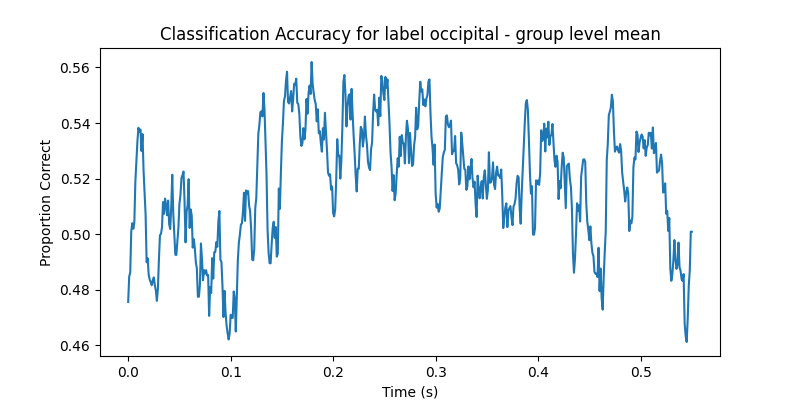

In [ ]:
#plotting the group level accuracy

plt.figure(figsize=(8,4))

plt.plot(times, mean_timecourse_source)

plt.title(f'Classification Accuracy for label occipital - group level mean')

plt.xlabel('Time (s)')

plt.ylabel('Proportion Correct')

plt.show()

In [ ]:
# performing a lot of t-tests
n_subjects, n_timepoints = arr.shape

chance_level = 0.5 

t_vals = np.zeros(n_timepoints)
p_vals = np.zeros(n_timepoints)

for t in range(n_timepoints):
    t_stat, p_val = ttest_1samp(arr[:, t], popmean=chance_level)
    t_vals[t] = t_stat
    p_vals[t] = p_val


significance = t_vals<=1.86

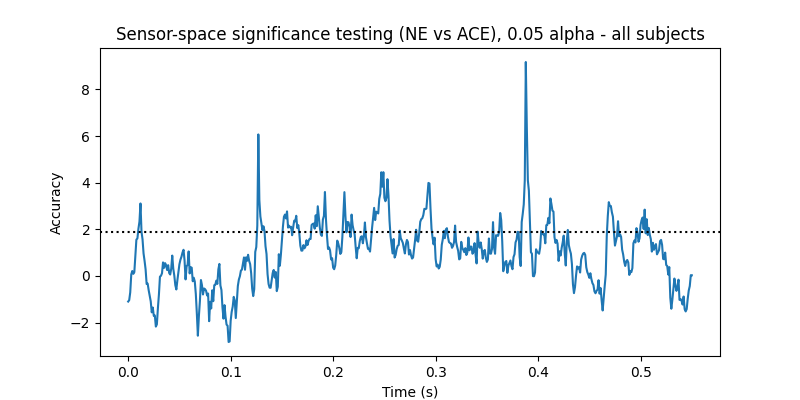

In [ ]:
#plotting the t-values
plt.figure(figsize=(8,4))
plt.plot(times, t_vals)
plt.axhline(y=1.90, color='k', linestyle=':', label='Significance threshold')
plt.title('Sensor-space significance testing (NE vs ACE), 0.05 alpha - all subjects')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.show()

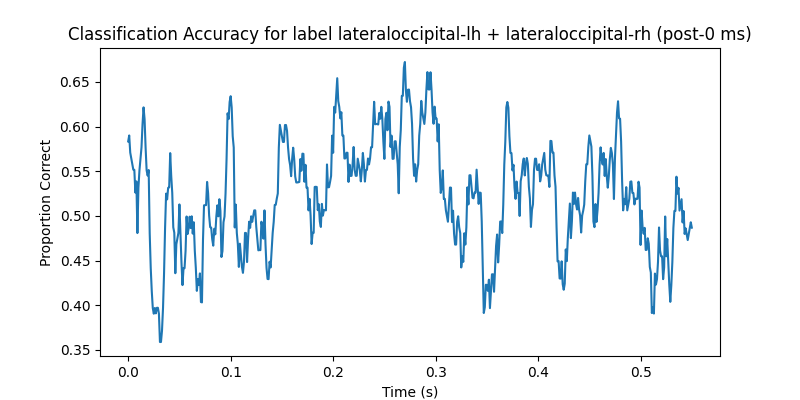

In [ ]:
# DECODING IN SOURCE SPACE (works)
# - Original code built for 1 participant at a time,  is not built to take a list and will not run unless fed a slightly different input
# -------------------------------

# PARAMETERS

# -------------------------------

n_jobs_outer = 64   # number of cores for time point parallelization

decimation = 1      # take every N-th sample (1 = no decimation)

cv_folds = 5

C_reg = 1e-3

label_index = -1    # label to decode  - this is lateral occipital

n_skip = 200        # number of initial samples to discard (pre-0 ms)

  

# -------------------------------

# APPLY INVERSE OPERATOR

# -------------------------------
stcs = mne.minimum_norm.apply_inverse_epochs(

    epochs_filtered, inverse_operator, lambda2=1, method='dSPM'

)

  

# -------------------------------

# READ LABELS

# -------------------------------

labels = mne.read_labels_from_annot('0170', subjects_dir=subjects_dir)

occipital_label = labels[22] + labels[23]

labels.append(occipital_label)

# -------------------------------

# EXTRACT LABELS

# -------------------------------

def extract_label(label, stcs):

    return [stc.in_label(label) for stc in stcs]

  

label_stcs = [extract_label(label, stcs) for label in labels]

  

# -------------------------------

# SELECT LABEL AND BUILD X

# -------------------------------

stcs_for_label = label_stcs[label_index]

label_name = labels[label_index].name

  

n_events = len(stcs_for_label)

n_label_vertices = stcs_for_label[0].data.shape[0]

n_samples = stcs_for_label[0].data.shape[1]

  

# Build X: shape = (n_events, n_vertices, n_samples)

X = np.zeros((n_events, n_label_vertices, n_samples))

for i in range(n_events):

    X[i, :, :] = stcs_for_label[i].data

  

# -------------------------------

# DISCARD FIRST 200 SAMPLES

# -------------------------------

X = X[:, :, n_skip:]

times = stcs_for_label[0].times[n_skip:]

n_samples = X.shape[2]

  

# -------------------------------

# LABELS

# -------------------------------

y = epochs_filtered.events[:, 2]

  

# -------------------------------

# CROSS-VALIDATION SETUP

# -------------------------------

cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

logr = LogisticRegression(C=C_reg, solver='liblinear', max_iter=1000)

sc = StandardScaler()

  

# -------------------------------

# FUNCTION TO DECODE ONE TIME SAMPLE

# -------------------------------

def decode_time_sample(sample_idx):

    this_X = X[:, :, sample_idx]

    this_X_std = sc.fit_transform(this_X)

    score = np.mean(cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=1))
    return score

  

# -------------------------------

# PARALLEL DECODING ACROSS TIME POINTS

# -------------------------------

scores_list_samples = Parallel(n_jobs=n_jobs_outer)(
    delayed(decode_time_sample)(t) for t in range(n_samples)

)

  

# -------------------------------

# PLOT RESULTS

# -------------------------------

plt.figure(figsize=(8,4))

plt.plot(times, scores_list_samples)

plt.title(f'Classification Accuracy for label {label_name} (post-0 ms)')

plt.xlabel('Time (s)')

plt.ylabel('Proportion Correct')

plt.show()